# Detección de Idiomas

El proyecto aborda un problema de clasificación supervisada en el ámbito del
procesamiento de lenguaje natural (NLP). El objetivo principal es construir un modelo que,
dado un texto, prediga a cuál de los 22 idiomas predefinidos pertenece.

### Dataset

El dataset utilizado es [Language Detect Artificial Intelligence Software](https://www.kaggle.com/datasets/emirhanai/language-detect-artificial-intelligence-software/data) de Kaggle.
Cuenta con 22000 registros, cada registro incluye dos columnas:

 - Text: La frase o cadena en uno de los 22 idiomas.
 - Language: La etiqueta correspondiente al idioma de la frase.

Se incluyen los siguientes idiomas: Estonio, Sueco, Inglés, Ruso, Rumano, Persa, Pashto, Español, Hindi, Coreano, Chino, Francés, Portugués, Indonesio, Urdú, Latín, Turco, Japonés, Neerlandés, Tamil, Tailandés, Árabe.

### 0. Importar librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

os.makedirs("plots", exist_ok=True)

### 1. Cargar el dataset y explorar los datos

In [2]:
df = pd.read_csv("language_detection.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   Language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [3]:
df.describe()

,Text,Language
count,22000,22000
unique,21859,22
top,haec commentatio automatice praeparata res ast...,Estonian
freq,48,1000


In [4]:
df.groupby('Language').describe()

Text                                                            \
           count unique                                                top   
Language                                                                     
Arabic      1000    998  يعمل الإنترنت بشكل جزئي وذلك بسبب البروتوكولات...   
Chinese     1000   1000  年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...   
Dutch       1000    996  bij de volkstelling in  werd het aantal inwone...   
English     1000   1000  the total high school population was now appro...   
Estonian    1000    999  aastakümned  aastad  aastad  aastad  aastad  a...   
French      1000    990  lévolution du nombre dhabitants est connue à t...   
Hindi       1000    990   ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...   
Indonesian  1000    975  bisby fa roskov yr orrell tm nicolson d paglin...   
Japanese    1000   1000  mozilla add-ons は、mozilla firefox、mozilla thun...   
Korean      1000   1000  세기부터 세기까지 고전 포르투갈어의 두 번째 시기는 대항해 시대와 맞물려 아시아와 ...   
Latin       1000    953  haec commentatio automatice praeparata res ast...   
Persian     1000   1000  مهمترین کارخانه‌های شهر کرمانشاه عبارتند از کا...   
Portugese   1000    997  segundo o censo norte-americano de  a sua popu...   
Pushto      1000    993  خواص - نسبتا اسيدي خواص لري په اوبو کى منحل دي...   
Romanian    1000   1000   aprilie sonda spațială messenger a nasa și-a ...   
Russian     1000    999  обеспечение совместно со структурными подразде...   
Spanish     1000    996  moyle p y j cech fishes an introduction to ich...   
Swedish     1000    992  inlandsklimat råder i trakten årsmedeltemperat...   
Tamil       1000    981  இக்கோயில் முதன்மைத் திருக்கோயில் என்ற வகைப்பாட...   
Thai        1000   1000  ใน พศ  หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...   
Turkish     1000   1000  molla nasreddinin kurucusu celil memmedgülüzad...   
Urdu        1000   1000  ذیل میں دیوبند کی خدمات اور کردار کا تفصیلی جا...   

                 
           freq  
Language         
Arabic        2  
Chinese       1  
Dutch         5  
English       1  
Estonian      2  
French        7  
Hindi         6  
Indonesian   12  
Japanese      1  
Korean        1  
Latin        48  
Persian       1  
Portugese     2  
Pushto        2  
Romanian      1  
Russian       2  
Spanish       5  
Swedish       3  
Tamil        17  
Thai          1  
Turkish       1  
Urdu          1

In [5]:
df.isnull().sum()

Text        0
Language    0
dtype: int64

#### 1.1 Chequeo de idiomas en el dataset

Se utiliza deep_translator para detectar el idioma de las frases en el dataset.

In [3]:
from langdetect import detect
from tqdm import tqdm

progress_bar = tqdm(total=len(df), desc="Processing", ncols=100)

def detect_language(text):
    progress_bar.update(1)
    try:
        return detect(text)
    except:
        return "unknown"

df['Detected_Language'] = df['Text'].apply(detect_language)
df.to_csv("language_detection_with_languages.csv", index=False)
#progress_bar.close()

Processing: 100%|███████████████████████████████████████████▉| 21979/22000 [01:24<00:00, 257.24it/s]

Processing: 100%|████████████████████████████████████████████| 22000/22000 [01:40<00:00, 257.24it/s]

Se hace un mapeo de las abreviaturas de los idiomas detectados a los idiomas del dataset, sin incluir los que no pudieron ser detectados por langdetect.

In [15]:
df = pd.read_csv("language_detection_with_languages.csv")

language_mapping = {
    'et': 'Estonian',
    'sv': 'Swedish',
    'th': 'Thai',
    'ta': 'Tamil',
    'nl': 'Dutch',
    'ja': 'Japanese',
    'tr': 'Turkish',
    'ur': 'Urdu',
    'id': 'Indonesian',
    'pt': 'Portugese',
    'fr': 'French',
    'zh-cn': 'Chinese',
    'zh-tw': 'Chinese',
    'ko': 'Korean',
    'hi': 'Hindi',
    'es': 'Spanish',
    'fa': 'Persian',
    'ro': 'Romanian',
    'ru': 'Russian',
    'en': 'English',
    'ar': 'Arabic',
    'la': 'Latin',
    'ps': 'Pushto',
    'unknown': 'Unknown'
}

df['Detected_Language'] = df['Detected_Language'].apply(lambda x: language_mapping.get(x, 'Unknown'))

df_filtered = df[df['Detected_Language'] != 'Unknown']
mismatched_languages = df_filtered[df_filtered['Language'] != df_filtered['Detected_Language']]

print("Registros con idiomas no coincidentes:")
print(mismatched_languages[['Language', 'Detected_Language', 'Text']])

mismatched_languages.to_csv("mismatched_languages.csv", index=False)

Registros con idiomas no coincidentes:
        Language Detected_Language  \
1        Swedish           English   
18     Portugese           English   
27        Pushto           Persian   
35         Latin          Romanian   
42         Latin           English   
...          ...               ...   
21928      Latin          Romanian   
21945     Pushto           Persian   
21947     Pushto           English   
21961       Urdu            Arabic   
21990     Pushto           Persian   

                                                    Text  
1      sebes joseph pereira thomas  på eng the jesuit...  
18     besemer s van der geest v murray j bijleveld c...  
27     لویي په کالونیو کې د ظلم کولو خلاف وو او له خل...  
35     imprimat psalterium quzhayae librum primum imp...  
42     lock helen  "a mans story is his gris-gris" is...  
...                                                  ...  
21928  kalmia anglice sheep-laurel lambkill calfkill ...  
21945  ارواښاد استاد مجروح له دې

In [16]:
from deep_translator import GoogleTranslator

language_mapping_inv = {v: k for k, v in language_mapping.items()}
progress_bar.close()
progress_bar = tqdm(total=len(mismatched_languages), desc="Processing", ncols=100)

def translate_text(row):
    target_language = language_mapping_inv.get(row['Language'])
    text = row['Text']

    progress_bar.update(1)

    if target_language == "zh-cn":
        target_language = "zh-CN"
    elif target_language == "zh-tw":
        target_language = "zh-TW"

    if row['Language'] == "Pushto" and row['Detected_Language'] == "Persian":
        return text # No se traduce porque son idiomas parecidos y el detector de idiomas no los distingue bien

    try:
        if target_language == None:
            print("target_language: ", row['Language'])
            print("target_language abb: ", target_language)
        translated = GoogleTranslator(source="auto", target=target_language).translate(text)
        return translated
    except Exception as e:
        print(f"Error en la traducción para el texto en el índice {row.name}: {e}")
        return None

mismatched_languages['Translated_Text'] = mismatched_languages.apply(translate_text, axis=1)
print(mismatched_languages[['Language', 'Detected_Language', 'Text', 'Translated_Text']])
mismatched_languages.to_csv("translated_mismatched_languages.csv", index=False)

Processing: 100%|███████████████████████████████████████████████| 2051/2051 [08:10<00:00,  3.09it/s]

        Language Detected_Language  \
1        Swedish           English   
18     Portugese           English   
27        Pushto           Persian   
35         Latin          Romanian   
42         Latin           English   
...          ...               ...   
21928      Latin          Romanian   
21945     Pushto           Persian   
21947     Pushto           English   
21961       Urdu            Arabic   
21990     Pushto           Persian   

                                                    Text  \
1      sebes joseph pereira thomas  på eng the jesuit...   
18     besemer s van der geest v murray j bijleveld c...   
27     لویي په کالونیو کې د ظلم کولو خلاف وو او له خل...   
35     imprimat psalterium quzhayae librum primum imp...   
42     lock helen  "a mans story is his gris-gris" is...   
...                                                  ...   
21928  kalmia anglice sheep-laurel lambkill calfkill ...   
21945  ارواښاد استاد مجروح له دې ټولو ښېگنگو سربېره ي...   
219

/tmp/ipykernel_72173/935996383.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_languages['Translated_Text'] = mismatched_languages.apply(translate_text, axis=1)


In [17]:
# Actualizar los textos en el dataset original
for idx, row in mismatched_languages.iterrows():
    if pd.notnull(row['Translated_Text']):  # Asegurarse de que haya texto traducido
        df.at[row.name, 'Text'] = row['Translated_Text']

# Guardar el dataset actualizado
df.to_csv("updated_language_dataset.csv", index=False)

### 5. Preprocesamiento

El texto se convierte a minúsculas, se eliminan los números, signos de puntación, tabulaciones y saltos de línea. No se eliminan caracteres especiales, ya que pueden ser relevantes para la clasificación de idiomas.

In [23]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[.,\t\n\r0-9]', '', text)
    return text

df['Text'] = df['Text'].apply(clean_text)
examples = df.groupby('Language').head(1)[['Language', 'Text']]
examples

,Language,Text
0,Estonian,klement gottwaldi surnukeha palsameeriti ning ...
1,Swedish,sebes joseph pereira thomas om jesuiterna och ...
2,Thai,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...
3,Tamil,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...
4,Dutch,de spons behoort tot het geslacht haliclona en...
5,Japanese,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...
6,Turkish,tsutinalar i̇ngilizce tsuutina kanadada albert...
7,Latin,müller mox figura centralis circulorum doctoru...
8,Urdu,برقی بار electric charge تمام زیرجوہری ذرات کی...
10,Indonesian,kemunculan pertamanya adalah ketika mencium ka...


#### 1.1. Visualizar la distribución de idiomas en el dataset

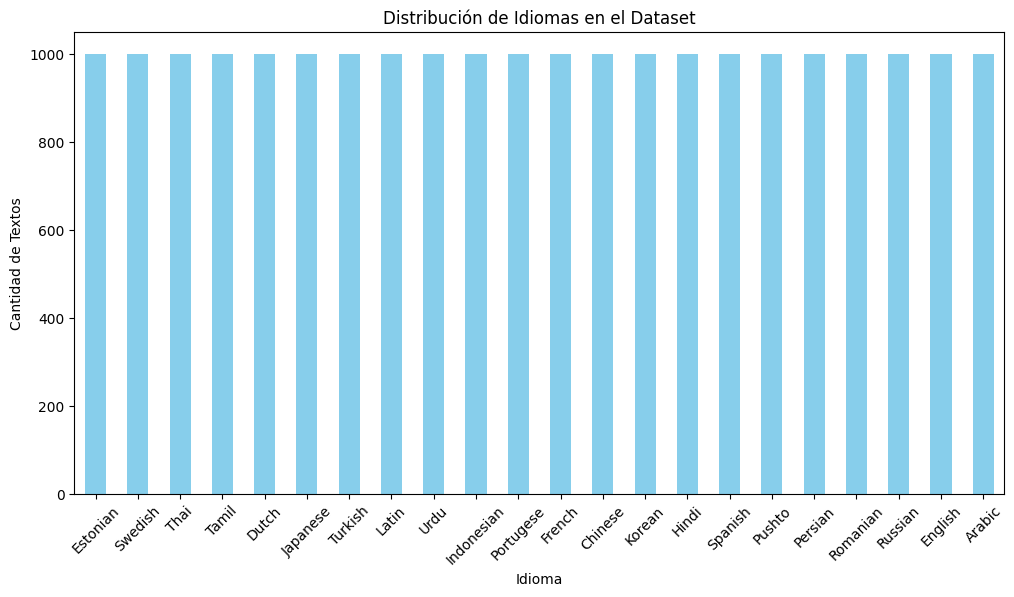

In [24]:
language_counts = df['Language'].value_counts()

plt.figure(figsize=(12, 6))
language_counts.plot(kind='bar', color='skyblue')
plt.title("Distribución de Idiomas en el Dataset")
plt.xlabel("Idioma")
plt.ylabel("Cantidad de Textos")
plt.xticks(rotation=45)
plt.savefig("plots/language_distribution.png")
plt.show()

#### 1.2 Analizar la longitud de los textos por idioma

<Figure size 1400x600 with 0 Axes>

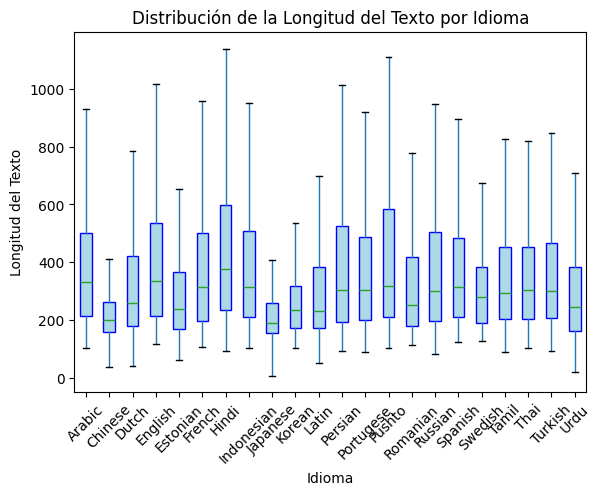

In [19]:
df['Text_length'] = df['Text'].str.len()

plt.figure(figsize=(14, 6))
df.boxplot(column='Text_length', by='Language', grid=False, showfliers=False, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='blue'))
plt.title("Distribución de la Longitud del Texto por Idioma")
plt.suptitle("")
plt.xlabel("Idioma")
plt.ylabel("Longitud del Texto")
plt.xticks(rotation=45)
plt.savefig("plots/text_length_distribution.png")
plt.show()

### 4. Generar nubes de palabras para idiomas específicos

**En inglés**

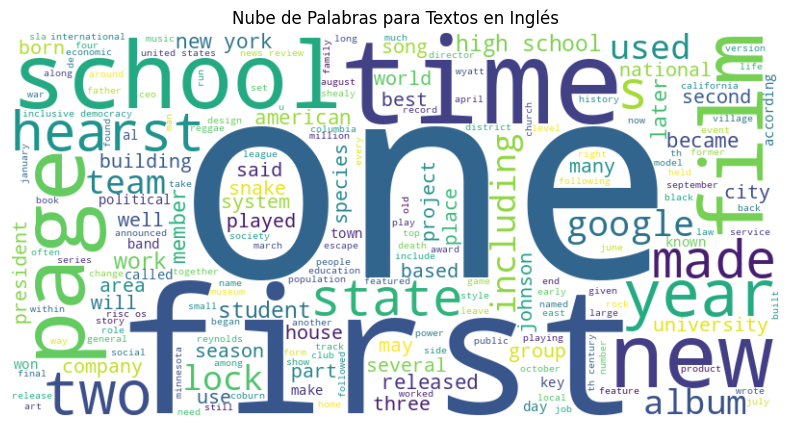

In [20]:
english_texts = " ".join(df[df['Language'] == 'English']['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(english_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras para Textos en Inglés")
plt.savefig("plots/english_wordcloud.png")
plt.show()

**En español**

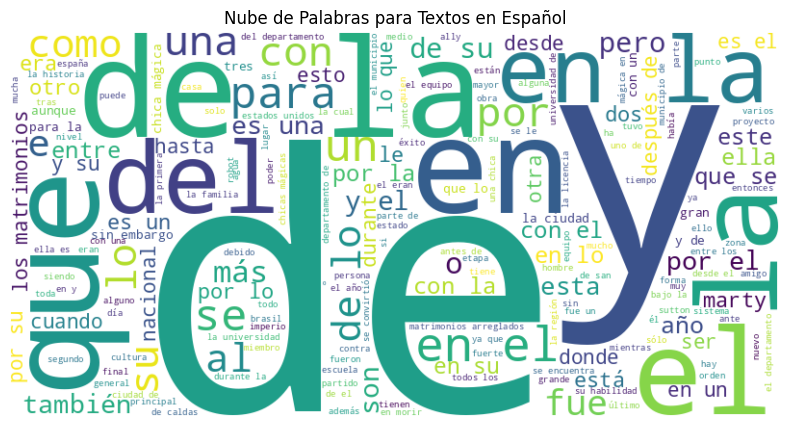

In [21]:
spanish_texts = " ".join(df[df['Language'] == 'Spanish']['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spanish_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras para Textos en Español")
plt.savefig("plots/spanish_wordcloud.png")
plt.show()

### 6. Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

In [25]:
X = df['Text']
y = df['Language']

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Language'], test_size=0.2, stratify=df['Language'])


### Convertir texto a Bag of Words

In [26]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### Entrenar un modelo Naive Bayes

In [27]:
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)

MultinomialNB()

### Evaluar el modelo Naive Bayes

In [28]:
y_pred = nb_model.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9561363636363637

Classification Report:
               precision    recall  f1-score   support

      Arabic       0.64      1.00      0.78       200
     Chinese       0.96      0.50      0.66       200
       Dutch       0.98      0.97      0.98       200
     English       0.82      1.00      0.90       200
    Estonian       0.99      1.00      1.00       200
      French       0.95      1.00      0.98       200
       Hindi       1.00      1.00      1.00       200
  Indonesian       0.99      0.99      0.99       200
    Japanese       1.00      0.62      0.77       200
      Korean       1.00      0.99      1.00       200
       Latin       0.99      0.98      0.99       200
     Persian       1.00      1.00      1.00       200
   Portugese       1.00      1.00      1.00       200
      Pushto       1.00      0.99      0.99       200
    Romanian       0.99      0.99      0.99       200
     Russian       0.99      0.99      0.99       200
     Spanish       0.98    

### Matriz de Confusión Naive Bayes

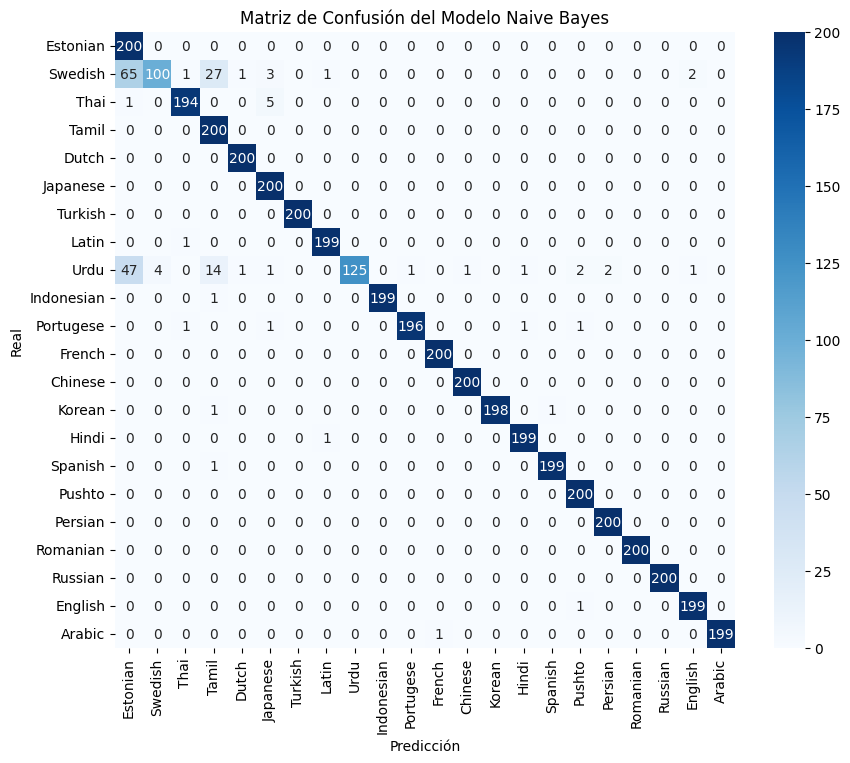

<Figure size 640x480 with 0 Axes>

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['Language'].unique(), yticklabels=df['Language'].unique())
plt.title("Matriz de Confusión del Modelo Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
plt.savefig("plots/nb_confusion_matrix.png")

Luego de analizar la matriz de confusión, se detectó que muchos idiomas eran predecidos como tamil, a pesar de ser muy distintos a este idioma. Gracias a esto, se detectó que los textos de este idioma incluían menciones o partes de su texto en otros idiomas, algunos incluso directamente en otros idiomas. A continuación se identifican los mismos y se reemplazan por su traducción correspondiente.

### Curva ROC Naive Bayes

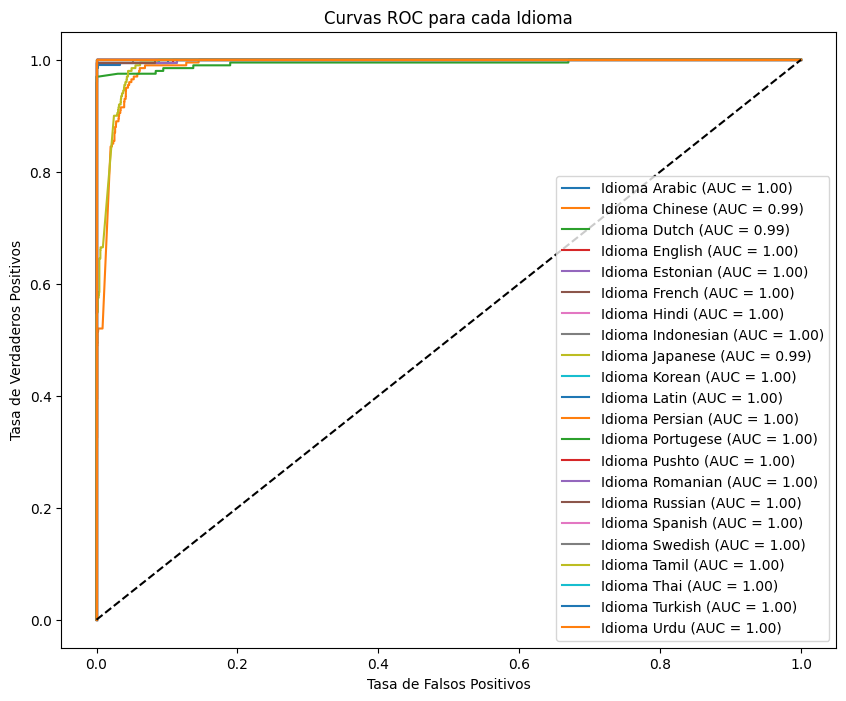

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_bin = lb.fit_transform(y_test)

y_prob = nb_model.predict_proba(X_test_bow)

plt.figure(figsize=(10, 8))
for i in range(len(df['Language'].unique())):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Idioma {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada Idioma')
plt.legend(loc="lower right")
plt.show()
plt.savefig("plots/nb_roc_curves.png")